In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
""" Optimization Algorithm """
""" New Matrix """
def newMat_2(x, Ut,Lt,Vt):
    l0,l1 = Lt[0], Lt[1]
    U_new = np.zeros((Ut.shape), dtype=np.cfloat)
    for i in range(Ut.shape[0]):
      U_new[i][0] = np.cos(x[i]) / l0
      U_new[i][1] = (np.sin(x[i]) / l1) * np.exp(1j*x[i+Ut.shape[0]])
    return np.dot(np.dot(U_new,np.diag(Lt)), Vt)


def newMat_3(x, Ut,Lt,Vt):
    l0,l1,l2 = Lt[0], Lt[1], Lt[2]
    U_new = np.zeros((Ut.shape), dtype=np.cfloat)
    for i in range(Ut.shape[0]):
      U_new[i][0] = np.cos(x[i]) / l0
      U_new[i][1] = (np.sin(x[i]) / l1) * (np.cos(x[i+Ut.shape[0]])) * np.exp(1j*x[i+2*Ut.shape[0]])
      U_new[i][2] = (np.sin(x[i]) / l2) * (np.sin(x[i+Ut.shape[0]])) * np.exp(1j*x[i+3*Ut.shape[0]])
    return np.dot(np.dot(U_new,np.diag(Lt)), Vt)


def newMat_4(x, Ut,Lt,Vt):
    l0,l1,l2,l3 = Lt[0], Lt[1], Lt[2], Lt[3]
    U_new = np.zeros((Ut.shape), dtype=np.cfloat)
    for i in range(Ut.shape[0]):
      U_new[i][0] = (np.cos(x[i]) / l0) * (np.cos(x[i+Ut.shape[0]]))
      U_new[i][1] = (np.cos(x[i]) / l1) * (np.sin(x[i+Ut.shape[0]])) * np.exp(1j*x[i+3*Ut.shape[0]])
      U_new[i][2] = (np.sin(x[i]) / l2) * (np.cos(x[i+2*Ut.shape[0]])) * np.exp(1j*x[i+4*Ut.shape[0]])
      U_new[i][3] = (np.sin(x[i]) / l3) * (np.sin(x[i+2*Ut.shape[0]])) * np.exp(1j*x[i+5*Ut.shape[0]])
    return np.dot(np.dot(U_new,np.diag(Lt)), Vt)

""" Cost Function """
def costFn(x, Ut,Lt,Vt,B,k):
    if k==2:
      Bp = newMat_2(x, Ut, Lt, Vt)
    elif k==3:
      Bp = newMat_3(x, Ut, Lt, Vt)
    elif k==4:
      Bp = newMat_4(x, Ut, Lt, Vt)
    else:
      return 0
    loss = np.linalg.norm(B**2 - np.abs(Bp)**2)
    return (loss)

In [3]:
""" Calculating losses when k is in (2,3) and tol is in (1e-10, 1e-5, 1e-3)
a 3x3 matrix is used for experiment k=2 and tol in (1e-10, 1e-5, 1e-3)
a 4x4 matrix is used for the experiment k=3 and tol in (1e-10, 1e-5, 1e-3) """

res = np.zeros((2400,4))
count = 0
for k in [2,3,4]:
    print('\n')
    print("k = ", k)
    for i in range(100):
      if(i%10==0):
        print('\n')
        print(i, " ", end='')
      A = np.random.rand(k+1, k+1)
      for j in range(k+1): A[j] /= sum(A[j])
      B = np.sqrt(A)
      U, L, V = np.linalg.svd(B, full_matrices=False)
      initial_guess = np.ones((2*(k+1)*(k-1),), dtype=np.longdouble)
      Ut = U[:, :k]
      Vt = V[:k]
      Lt = L[:k]
      Bt = np.dot(np.dot(Ut,np.diag(Lt)), Vt)
      for tol in ([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]):
        if(i%10==0): print(tol, " ", end=' ')        
        result = optimize.minimize(fun=costFn, x0=initial_guess, args=(Ut,Lt,Vt,B,k),
                                            tol=tol, method='Nelder-Mead', options={'maxiter':1e+10})
        res[count][0] = k
        res[count][1] = tol
        res[count][2] = (np.linalg.norm(B**2 - Bt**2))
        res[count][3] = costFn(result.x,Ut,Lt,Vt,B,k)
        count+=1



k =  2


0  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

10  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

20  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

30  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

40  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

50  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

60  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

70  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

80  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

90  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

k =  3


0  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

10  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

20  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001   0.001   

30  1e-10   1e-09   1e-08   1e-07   1e-06   1e-05   0.0001 

In [4]:
np.save('toltest_detail.npy',res)
#res = np.load('toltest_detail_2.npy')
res

array([[2.00000000e+00, 1.00000000e-10, 3.57707979e-02, 2.22917938e-02],
       [2.00000000e+00, 1.00000000e-09, 3.57707979e-02, 2.22917938e-02],
       [2.00000000e+00, 1.00000000e-08, 3.57707979e-02, 2.22917938e-02],
       ...,
       [4.00000000e+00, 1.00000000e-05, 4.14636323e-02, 3.54228252e-02],
       [4.00000000e+00, 1.00000000e-04, 4.14636323e-02, 3.95558455e-02],
       [4.00000000e+00, 1.00000000e-03, 4.14636323e-02, 4.12257334e-02]])

In [5]:
df = pd.DataFrame(res, columns=['k', 'tol', 'loss1', 'loss2'])
df['RI'] = (df['loss1']-df['loss2'])/df['loss1']
df.head()

,k,tol,loss1,loss2,RI
0,2.0,1.000000e-10,0.035771,0.022292,0.376816
1,2.0,1.000000e-09,0.035771,0.022292,0.376816
2,2.0,1.000000e-08,0.035771,0.022292,0.376816
3,2.0,1.000000e-07,0.035771,0.022292,0.376816
4,2.0,1.000000e-06,0.035771,0.022292,0.376816


In [6]:
gdf = df.groupby(['k', 'tol']).mean()
gdf

loss1     loss2        RI
k   tol                                       
2.0 1.000000e-10  0.112723  0.077813  0.306383
    1.000000e-09  0.112723  0.077813  0.306383
    1.000000e-08  0.112723  0.077813  0.306383
    1.000000e-07  0.112723  0.077813  0.306383
    1.000000e-06  0.112723  0.077813  0.306352
    1.000000e-05  0.112723  0.077813  0.306200
    1.000000e-04  0.112723  0.077936  0.298934
    1.000000e-03  0.112723  0.079889  0.144282
3.0 1.000000e-10  0.080122  0.028145  0.620063
    1.000000e-09  0.080122  0.028145  0.620063
    1.000000e-08  0.080122  0.028145  0.620063
    1.000000e-07  0.080122  0.028254  0.617544
    1.000000e-06  0.080122  0.029606  0.555557
    1.000000e-05  0.080122  0.030894  0.530575
    1.000000e-04  0.080122  0.033032  0.443623
    1.000000e-03  0.080122  0.037639  0.312549
4.0 1.000000e-10  0.052006  0.016453 -0.322464
    1.000000e-09  0.052006  0.016453 -0.322464
    1.000000e-08  0.052006  0.016459 -0.322545
    1.000000e-07  0.052006  0.019733 -1.382868
    1.000000e-06  0.052006  0.021893 -1.544019
    1.000000e-05  0.052006  0.024252 -2.308888
    1.000000e-04  0.052006  0.027870 -3.191942
    1.000000e-03  0.052006  0.038095 -4.303374

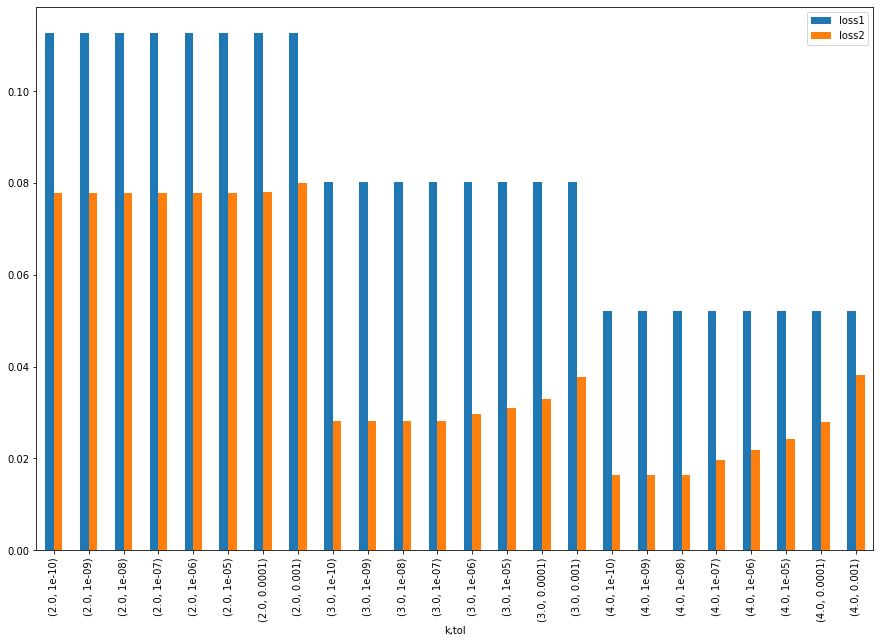

In [7]:
ax = gdf[['loss1','loss2']].plot(figsize=(15,10), kind='bar')
plt.show()

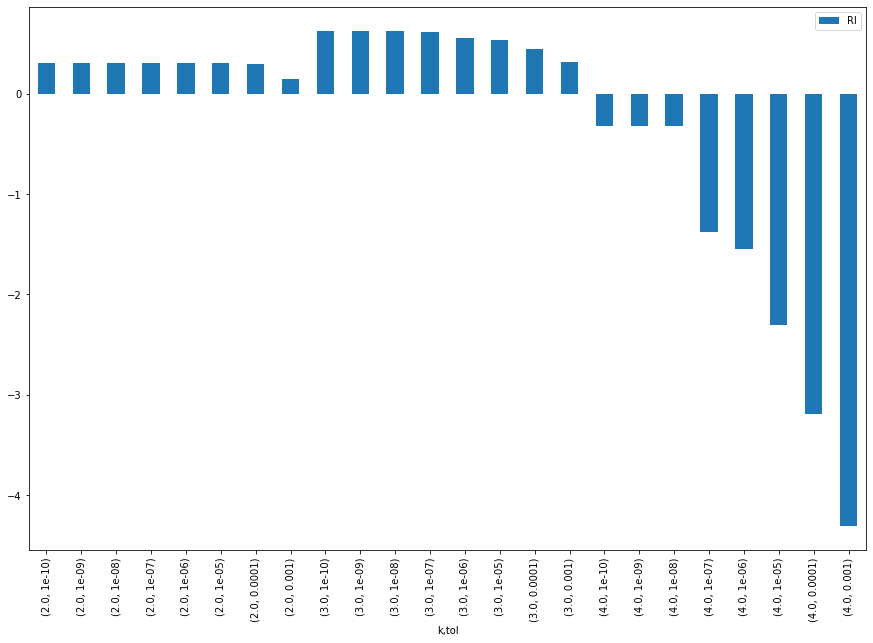

In [8]:
ax = gdf[['RI']].plot(figsize=(15,10), kind='bar')
plt.show()

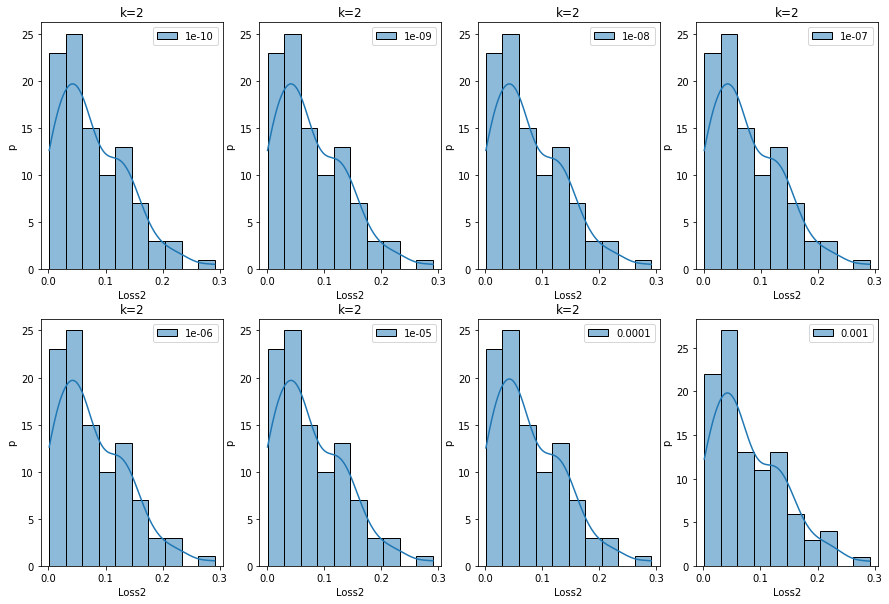

In [9]:
tollist = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
plt.figure(figsize=(15,10))
for i in range(8):
  plt.title("k=2")
  plt.subplot(2,4,i+1)
  sns.histplot(df.loc[(df.k==2) & (df.tol == tollist[i])]['loss2'], kde=True,label=str(tollist[i]), bins=10)
  plt.ylabel('p')
  plt.xlabel('Loss2')
  plt.legend()
plt.show()

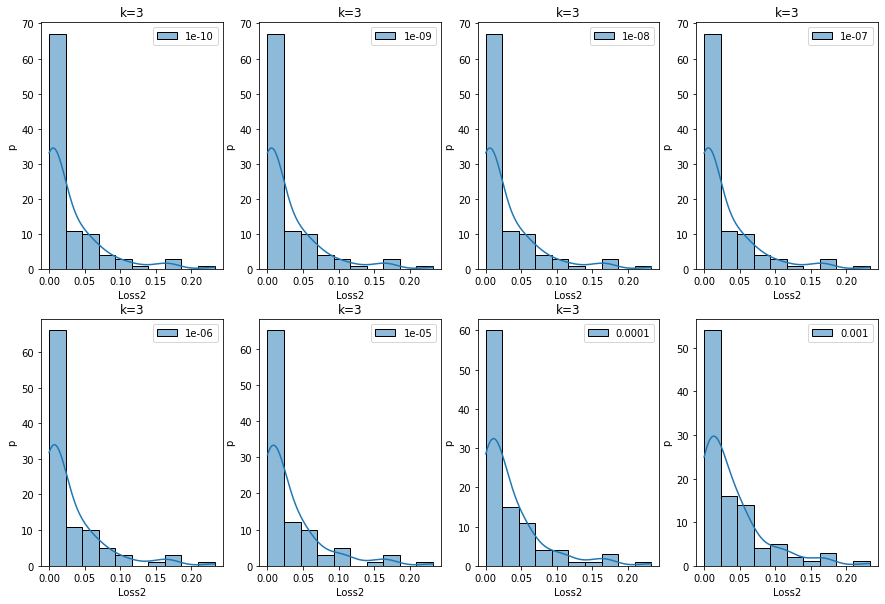

In [10]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.title("k=3")
  plt.subplot(2,4,i+1)
  sns.histplot(df.loc[(df.k==3) & (df.tol == tollist[i])]['loss2'], kde=True,label=str(tollist[i]), bins=10)
  plt.ylabel('p')
  plt.xlabel('Loss2')
  plt.legend()
plt.show()

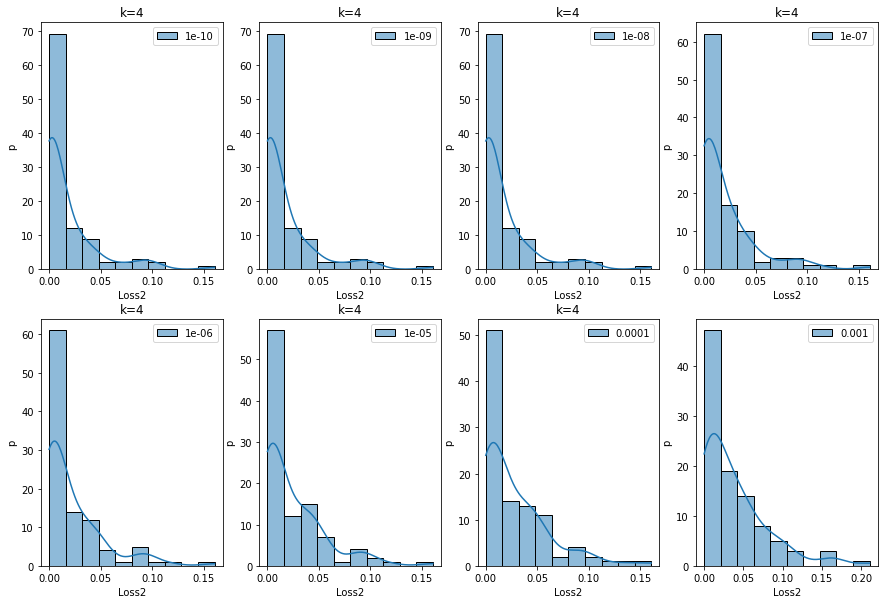

In [11]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.title("k=4")
  plt.subplot(2,4,i+1)
  sns.histplot(df.loc[(df.k==4) & (df.tol == tollist[i])]['loss2'], kde=True,label=str(tollist[i]), bins=10)
  plt.ylabel('p')
  plt.xlabel('Loss2')
  plt.legend()
plt.show()

In [12]:
sample1 = df.loc[(df.k==4) & (df.tol==1e-3)]
sample1.describe()

,k,tol,loss1,loss2,RI
count,100.0,1.000000e+02,100.000000,100.000000,100.000000
mean,4.0,1.000000e-03,0.052006,0.038095,-4.303374
std,0.0,2.179328e-19,0.040946,0.041993,16.314526
min,4.0,1.000000e-03,0.000048,0.000082,-107.732317
25%,4.0,1.000000e-03,0.014274,0.006736,-1.194986
50%,4.0,1.000000e-03,0.047563,0.023308,0.155023
75%,4.0,1.000000e-03,0.077966,0.052824,0.861300
max,4.0,1.000000e-03,0.177890,0.210590,0.998859


In [13]:
df.loc[(df.k==4)].mean()

k        4.000000
tol      0.000139
loss1    0.052006
loss2    0.022651
RI      -1.712320
dtype: float64